In [60]:
%matplotlib widget

# Load and preprocess data
import torch
from torch import nn
import numpy as np

from prep_data import get_all_outdoor_data_batched, preprocess_data_batched

import random

# A seed of 2023 was used to generate good_initialization.model
seed = 2023
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

pred_length = 5
seq_length = 16
train_ratio = 0.9
batch_size = 500
augment = False
remove_center = True


train_data, test_data, train_len, test_len = get_all_outdoor_data_batched(pred_length, seq_length, train_ratio, batch_size, augment=augment, remove_center=remove_center)
# train_data, test_data, train_len, test_len = preprocess_data_batched(17, pred_length, seq_length, train_ratio, batch_size, augment=augment, remove_center=remove_center)

print(train_len)
print(test_len)

26948
3000


In [61]:
seed = 2023
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

mode = "train_initial_weights"
# mode = "tune_existing_weights"

def cuda_get_device():
	is_cuda = torch.cuda.is_available()
	if is_cuda:
		return torch.device("cuda")
	else:
		print("GPU not available, CPU used")
		return torch.device("cpu")

device = cuda_get_device()

class GRUModel(nn.Module):
	def __init__(self, input_size, output_size, hidden_dim, GRU_dropout, second_layer=False):
		super(GRUModel, self).__init__()
		self.hidden_dim = hidden_dim
		self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_dim, batch_first=True)
		self.second_layer = second_layer
		if second_layer:
			self.fc1= nn.Linear(hidden_dim, 10)
			self.fc2 = nn.Linear(10, output_size)
		else:
			self.fc1 = nn.Linear(hidden_dim, output_size)
		self.dropout = nn.Dropout(p=GRU_dropout)
	
	def forward(self, x):
		hidden = self.gru(x)[0]
		hidden_drop = self.dropout(hidden)
		if self.second_layer:
			out = self.fc1(hidden_drop)
			out = self.fc2(out)
		else:
			out = self.fc1(hidden_drop)
		return out

# Model Hyperparameters
hidden_state_size = 20
dropout = 0.0
second_layer = True
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.2]).to(device))
# criterion = nn.BCEWithLogitsLoss()
if mode == "train_initial_weights":
	n_epochs = 2000
	lr = 0.02
	gamma = 0.4
	milestones = [150, 400, 800, 1200, 1700]

# 	model.load_state_dict(torch.load("C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\saved_parameters\\augment_initialization.model"))

if remove_center:
	input_size = 54
else:
	input_size = 64
model = GRUModel(input_size=input_size, output_size=1, hidden_dim=hidden_state_size, GRU_dropout=dropout, second_layer=second_layer)

model.to(device)

	
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# Training Run
loss_sequence = []
for epoch in range(1, n_epochs + 1):
	epoch_losses = torch.tensor([0],dtype=float).to(device)
	# Avoid shuffling the original train_data to ensure reproducibility
	shuffled_train_data = train_data
	# random.shuffle(shuffled_train_data)
	for data in shuffled_train_data:
		optimizer.zero_grad()
		input_data = data[0].float().to(device)
		target_pred = data[1].unsqueeze(1).float().to(device)
		output = model(input_data)[:,-1,:]
		loss = criterion(output, target_pred)
		loss.backward()
		optimizer.step()
		epoch_losses += loss
	scheduler.step()
	avg_epoch_loss = epoch_losses.to('cpu').item()/len(train_data)
	loss_sequence.append(avg_epoch_loss)
	if epoch%5 == 0:
		print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
		print("Loss: {:.4f}".format(avg_epoch_loss))

Epoch: 5/2000............. Loss: 0.7269
Epoch: 10/2000............. Loss: 0.7087
Epoch: 15/2000............. Loss: 0.6882
Epoch: 20/2000............. Loss: 0.6891
Epoch: 25/2000............. Loss: 0.6830
Epoch: 30/2000............. Loss: 0.6702
Epoch: 35/2000............. Loss: 0.6673
Epoch: 40/2000............. Loss: 0.6624
Epoch: 45/2000............. Loss: 0.6555
Epoch: 50/2000............. Loss: 0.6569
Epoch: 55/2000............. Loss: 0.6504
Epoch: 60/2000............. Loss: 0.6480
Epoch: 65/2000............. Loss: 0.6440
Epoch: 70/2000............. Loss: 0.6434
Epoch: 75/2000............. Loss: 0.6424
Epoch: 80/2000............. Loss: 0.6426
Epoch: 85/2000............. Loss: 0.6373
Epoch: 90/2000............. Loss: 0.6365
Epoch: 95/2000............. Loss: 0.6372
Epoch: 100/2000............. Loss: 0.6323
Epoch: 105/2000............. Loss: 0.6324
Epoch: 110/2000............. Loss: 0.6330
Epoch: 115/2000............. Loss: 0.6293
Epoch: 120/2000............. Loss: 0.6267
Epoch: 125/2

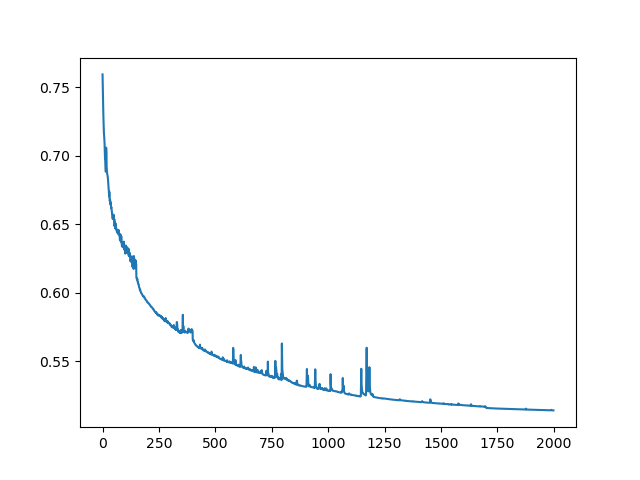

In [72]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_sequence)
plt.show()

In [26]:
plt.close('all')

In [52]:
model.eval()

num_blocks_missed = 0
num_false_positives = 0
with torch.no_grad():
	for data in train_data:
		input_data = data[0].float().to(device)
		target_pred = data[1].unsqueeze(1)
		output = torch.round(torch.sigmoid(model(input_data)[:,-1,:])).cpu()
		err = (output - target_pred).numpy()
		num_blocks_missed += np.sum(err < 0)
		num_false_positives += np.sum(err > 0)
	
print("Number of blocks missed: {}".format(num_blocks_missed))
print("Number of false positives: {}".format(num_false_positives))
print("Error rate: {}".format((num_blocks_missed + num_false_positives)/train_len))

Number of blocks missed: 1943
Number of false positives: 2405
Error rate: 0.16134778091138488


In [53]:
model.eval()

num_blocks_missed = 0
num_false_positives = 0
with torch.no_grad():
	for data in test_data:
		input_data = data[0].float().to(device)
		target_pred = data[1].unsqueeze(1)
		output = torch.round(torch.sigmoid(model(input_data)[:,-1,:])).cpu()
		err = (output - target_pred).numpy()
		num_blocks_missed += np.sum(err < 0)
		num_false_positives += np.sum(err > 0)
	
print("Number of blocks missed: {}".format(num_blocks_missed))
print("Number of false positives: {}".format(num_false_positives))
print("Error rate: {}".format((num_blocks_missed + num_false_positives)/test_len))

Number of blocks missed: 1004
Number of false positives: 398
Error rate: 0.4673333333333333


In [26]:
torch.save(model.state_dict(),"C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\saved_parameters\\all_data.model")

In [63]:
from prep_data import preprocess_data_3

scen_17_train, scen_17_test = preprocess_data_3(17, pred_length, seq_length, train_ratio, augment=augment, remove_center=remove_center)
scen_18_train, scen_18_test = preprocess_data_3(18, pred_length, seq_length, train_ratio, augment=augment, remove_center=remove_center)
scen_19_train, scen_19_test = preprocess_data_3(19, pred_length, seq_length, train_ratio, augment=augment, remove_center=remove_center)
scen_20_train, scen_20_test = preprocess_data_3(20, pred_length, seq_length, train_ratio, augment=augment, remove_center=remove_center)
scen_21_train, scen_21_test = preprocess_data_3(21, pred_length, seq_length, train_ratio, augment=augment, remove_center=remove_center)

scen_test = [scen_17_test, scen_18_test, scen_19_test, scen_20_test, scen_21_test]

In [71]:
# from prep_data import preprocess_data_3

model.eval()

# scen_train, scen_test = preprocess_data_3(17, pred_length, seq_length, train_ratio, augment=augment, remove_center=remove_center)

scen_indx = 4

num_blocks_missed = 0
num_false_positives = 0
with torch.no_grad():
	for data in scen_test[scen_indx]:
		input_data = torch.from_numpy(data[0]).float().to(device)
		target_pred = torch.tensor(data[1]).unsqueeze(0)
		output = torch.round(torch.sigmoid(model(input_data)[-1])).cpu()
		err = (output - target_pred).numpy()
		num_blocks_missed += np.sum(err < 0)
		num_false_positives += np.sum(err > 0)

print("Number of blocks missed: {}".format(num_blocks_missed))
print("Number of false positives: {}".format(num_false_positives))
print("Error rate: {}".format((num_blocks_missed + num_false_positives)/len(scen_test[scen_indx])))

Number of blocks missed: 51
Number of false positives: 49
Error rate: 0.4166666666666667
